# Tarea 2, pregunta 3: "Encoder-Decoder sobre Texto"

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow GPU stuff :v
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Modificar estilos de jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

# Tamaño fuente matplotlib
font = {'family' : 'normal', 'weight' : 'normal', 'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

In [2]:
# Se importa el dataset
import pandas as pd
df = pd.read_csv("dataset_3/spa.txt", sep="\t", names=["Source","Target"])
display(df.head())
df.shape

,Source,Target
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


(123376, 2)

## a)
Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

In [3]:
display(df.tail())

,Source,Target
123371,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
123372,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
123373,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
123374,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."
123375,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...


## b)
Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.

In [4]:
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    if where =="target":
        tokenize_text = tokenize_text + ["#end"] 
    return tokenize_text
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))

In [5]:
from sklearn.model_selection import train_test_split
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=10000, random_state=22)

# Se van a seleccionar 35000 elementos
idx = np.random.choice(np.arange(len(X_train_l)), 25000, replace=False)
X_train_l = np.asarray(X_train_l)[idx]
Y_train_l = np.asarray(Y_train_l)[idx]

X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=10000, random_state=22)

## c)
Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario ¿De qué tamaño es el vocabulario de entrada y salida? ¿La diferencia de ésto podría ser un factor importante?

In [6]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]

vocab_source = create_vocab(X_train_l, min_count=3)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = {i+1 : w for i, w in enumerate(vocab_target)}
n_words_t = len(vocab_target)

Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?

In [7]:
""" Source/input data """

def convert_text_to_index(X, Y, vocabulary):
    transformed_data = list()
    for i in range(len(X)):
        words_in_vocabulary = True
        trasnformed_sentence = []
        for word in X[i]:
            if word in vocabulary:
                trasnformed_sentence.append(vocabulary[word])
            else:
                words_in_vocabulary = False
                break
        if words_in_vocabulary:
            transformed_data.append(trasnformed_sentence)
            
    return transformed_data
            
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataX_val = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
dataX_test = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_test_l]

# dataX_train = convert_text_to_index(X_train_l, word2idx_s)
# dataX_valid = convert_text_to_index(X_val_l, word2idx_s)
# dataX_test = convert_text_to_index(X_test_l, word2idx_s)

""" Target/output data """
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]
dataY_val = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 
dataY_test = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_test_l] 

Se podría evitar generando el vocabulario a partir de TODO el dataset antes de particionarlo en los distintos conjuntos de entrenamiento, validación y testing. Así se debería disminuir la posibilidad de que una palabra no se encuentre presente en el vocabulario. Otra cosa que se podría hacer es disminuir la cantidad mínima de ocurrencias de una palabra para que esta sea conciderada en el vocabulario, actualmente está puesto en 3.

## d)
Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?

In [8]:
from keras.preprocessing import sequence
""" INPUT DATA (Origin language) """
max_inp_length = max(map(len, dataX_train)) # Se saca el largo de la sentencia más larga
print("Largo max inp: ", max_inp_length)
word2idx_s["PAD"] = 0 #padding symbol
idx2word_s[0] = "PAD"
n_words_s += 1  

# Se procede a aplicar el padding
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_val = sequence.pad_sequences(dataX_val, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])

""" OUTPUT DATA (Destination language) """
max_out_length = max(map(len,dataY_train)) 
print("Largo max out: ",max_out_length)
word2idx_t["PAD"] = 0 #padding symbol
idx2word_t[0] = "PAD"
n_words_t += 1  
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_val = sequence.pad_sequences(dataY_val, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])

Using TensorFlow backend.


Largo max inp:  24
Largo max out:  27


## e)
Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.

In [9]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]

In [10]:
from keras.utils import to_categorical
# Y_train = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_train])
# Y_val = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_val])
# Y_test = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_test])

## f)
Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen.
<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />
En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.

Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.

Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*). 

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, TimeDistributed, Dense, Dropout
EMBEDDING_DIM = 100
model_F = Sequential()
model_F.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_F.add(CuDNNGRU(64, return_sequences=True))
model_F.add(CuDNNGRU(128, return_sequences=False))

from keras.layers import RepeatVector
model_F.add(RepeatVector(max_out_length)) #conection

# Decoder
model_F.add(CuDNNGRU(128, return_sequences=True))
model_F.add(CuDNNGRU(64, return_sequences=True))
model_F.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_F.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 100)           239200    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 24, 64)            31872     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 128)               74496     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 27, 128)           0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 27, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 27, 64)            37248     
_________________________________________________________________
time

In [12]:
print(max_out_length)
print(Y_train.shape)
print(Y_val.shape)
Y_train = np.expand_dims(Y_train, axis=2)
Y_val = np.expand_dims(Y_val, axis=2)
Y_test = np.expand_dims(Y_test, axis=2)

27
(15000, 27)
(10000, 27)


In [13]:
Y_train[0][0]

array([1], dtype=int32)

Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*

In [14]:
model_F.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_F = model_F.fit(X_train, Y_train, epochs=5, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

# model_F.compile(optimizer='adam', loss='categorical_crossentropy')
# history_F = model_F.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_val, Y_val), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 18s 1ms/step - loss: 6.5620 - val_loss: 9.1324
Epoch 2/5
15000/15000 [==============================] - 9s 610us/step - loss: 5.6292 - val_loss: 9.9183
Epoch 3/5
15000/15000 [==============================] - 9s 577us/step - loss: 5.6196 - val_loss: 10.3356
Epoch 4/5
15000/15000 [==============================] - 9s 598us/step - loss: 5.6055 - val_loss: 10.6784
Epoch 5/5
15000/15000 [==============================] - 9s 570us/step - loss: 5.5830 - val_loss: 10.9566


/home/francisco/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


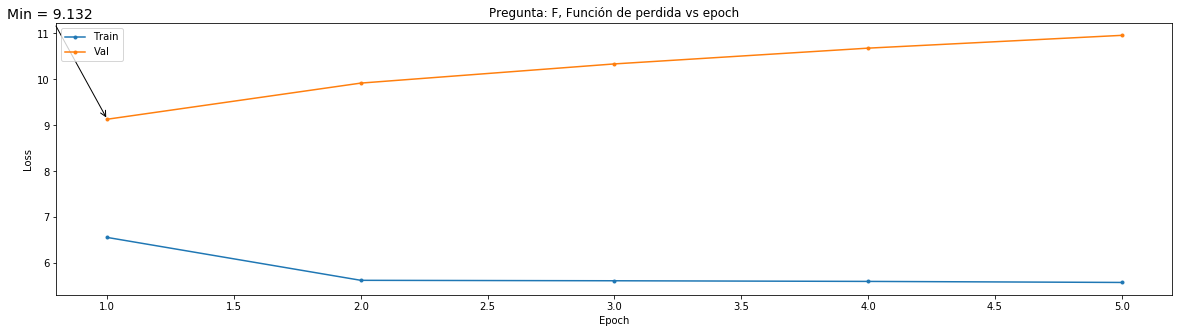

In [15]:
def chart_loss(history, epoch_number, question):
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['val_loss'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val') )
    plt.title("Pregunta: {}, Función de perdida vs epoch".format(question))

    max_index = np.argmin(history.history['val_loss'])
    max_value = history.history['val_loss'][max_index].round(3)
    plt.annotate('Min = {}'.format(max_value), xy=(max_index+1, max_value), xycoords='data', xytext=(-100, 100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))


    plt.show()

chart_loss(history_F, 5, "F")

## g)
Debido a lo costoso de tener una red completamente recurrente para entrenar y poder experimentar, cambie el modelo que procesa el *Encoder* por una red convolucional, reduciendo el número de capas pero aumentando las neuronas. Utilice tamaños de *kernel*  igual a 5 y funciones de activaciones relu. Se agregan capas de *BatchNormalization* debido a que en el *Decoder* contamos con redes recurrentes que tienen capa activación distinta a la usada por las convoluciones. La capa de *GlobalMaxPooling1d* es lo que permite reducir toda la información extraída a un único vector, como se realizó anteriormente con *return_sequences=False*, comente sobre la ganancia o desventaja de ésto *vs* la red neuronal.

In [16]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
model_G = Sequential()
model_G.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_G.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_G.add(BatchNormalization()) #for stability
model_G.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_G.add(BatchNormalization())
model_G.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model_G.add(RepeatVector(max_out_length)) #conection
model_G.add(CuDNNGRU(256, return_sequences=True))
model_G.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_G.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           239200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 256)           128256    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 256)           1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 256)           327936    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 256)           1024      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 27, 256)           0         
__________

In [17]:
model_G.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_G = model_G.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 18s 1ms/step - loss: 5.8206 - val_loss: 11.1055
Epoch 2/20
15000/15000 [==============================] - 13s 897us/step - loss: 5.3279 - val_loss: 11.6230
Epoch 3/20
15000/15000 [==============================] - 13s 851us/step - loss: 5.0322 - val_loss: 11.7995
Epoch 4/20
15000/15000 [==============================] - 13s 855us/step - loss: 4.7555 - val_loss: 12.3987
Epoch 5/20
15000/15000 [==============================] - 13s 863us/step - loss: 4.4988 - val_loss: 13.0444
Epoch 6/20
15000/15000 [==============================] - 13s 869us/step - loss: 4.2661 - val_loss: 13.2873
Epoch 7/20
15000/15000 [==============================] - 9s 592us/step - loss: 4.0434 - val_loss: 13.2158
Epoch 8/20
15000/15000 [==============================] - 8s 560us/step - loss: 3.8433 - val_loss: 13.2725
Epoch 9/20
1

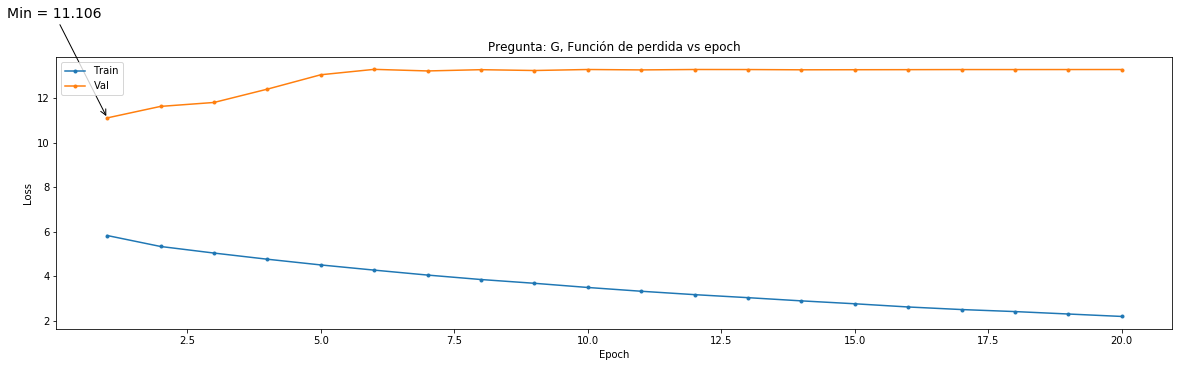

In [18]:
chart_loss(history_G, 20, "G")

## h)
Visualice lo aprendido por el modelo sobre algunos datos del conjunto de entrenamiento y validación, comente lo observado.

In [19]:
def predict_words(y_indexs, data="target"):
    """ Predict until '-#end-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["#end"]:
                    return return_val                
    return return_val
n_s = 100
idx = np.random.choice(np.arange(Y_val.shape[0]), size=n_s, replace=False)
Y_pred = model_G.predict_classes(X_val[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_val[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_val[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_pred[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))
    print('\n')

Texto source:  they havent come back home yet
Texto target real:  ellos aún no han vuelto a la casa #end
Texto target predicho:  no no a casa casa #end


Texto source:  tom is a good employee he gets things done quickly and
Texto target real:  tom es un buen empleado él hace las cosas de forma y #end
Texto target predicho:  tom es es que que que buena #end


Texto source:  our land is being taken over
Texto target real:  se están de nuestra tierra #end
Texto target predicho:  se se de de #end


Texto source:  tom is standing near the window
Texto target real:  tom está parado cerca de la ventana #end
Texto target predicho:  tom está la la la la la la ventana #end


Texto source:  the bus is
Texto target real:  el autobús es lento #end
Texto target predicho:  el el el #end


Texto source:  tom and mary have gone their ways
Texto target real:  tom y mary han ido por #end
Texto target predicho:  tom y mary mary mary mary mary #end


Texto source:  i know that it is highly unlikely that an